# Contrução de fronteira eficiente de portfolio utilizando solver e comparação com biblioteca riskfolio.
elaboração para fins didaticos - Não é uma recomendação de investimento.


In [2]:
#%% Importando Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = 'w'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'gray'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['axes.axisbelow'] = True
import numpy as np
import scipy.optimize as solver
import yfinance as yf
from datetime import datetime
import seaborn as sns
import riskfolio as rp


## Coleta de Dados
Será utilizado dados de fechamento do Euro, Dolar e Libra.

Os dados serão coletados do Yahoo Finance, será utilizado o período desde de 2010.


In [3]:
tickers = ['EURUSD=X','USDBRL=X','GBPBRL=X']
start = '2010-01-01'
end = datetime.today()
portfolio = yf.download(tickers,start=start,end=end)['Adj Close']
portfolio.dropna(inplace=True)
portfolio = portfolio.rename(columns={
    'EURUSD=X': 'Euro',
    'USDBRL=X': 'Dólar',
    'GBPBRL=X': 'Libra'
})
tickers = portfolio.columns
portfolio['Euro'] = portfolio['Euro'] * portfolio['Dólar']
portfolio


[*********************100%%**********************]  3 of 3 completed


,Euro,Libra,Dólar
Date,,,
2010-01-04,2.479482,2.692600,1.7190
2010-01-05,2.495367,2.774500,1.7370
2010-01-06,2.494058,2.769400,1.7315
2010-01-07,2.489763,2.683000,1.7389
2010-01-08,2.496001,2.701100,1.7320
...,...,...,...
2024-06-03,5.691773,6.683744,5.2444
2024-06-04,5.725287,6.724745,5.2490
2024-06-05,5.754005,6.747638,5.2877


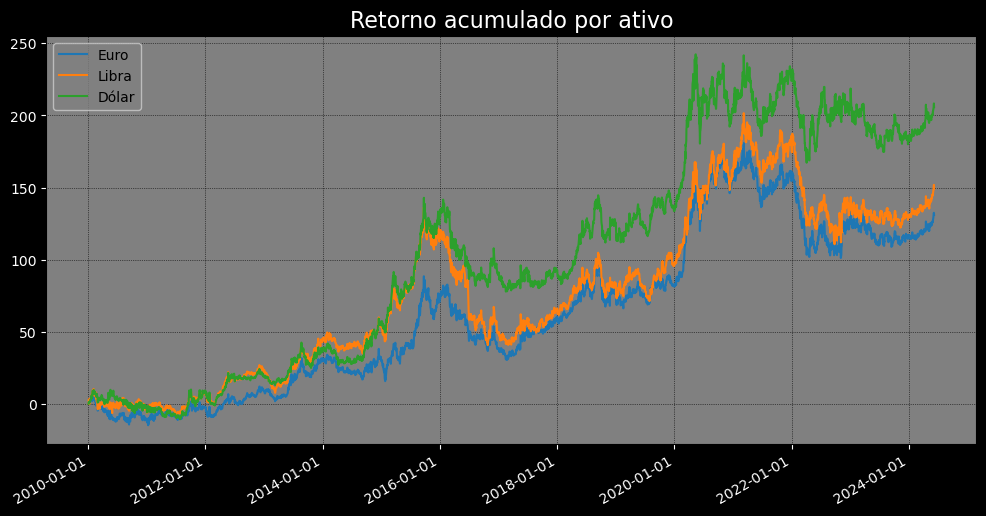

In [4]:
plt.figure(figsize=(12,6))
plt.plot(portfolio.index,((portfolio - portfolio.iloc[0]) / portfolio.iloc[0])*100)
plt.legend(tickers)
plt.title('Retorno acumulado por ativo')
plt.grid()
import matplotlib.dates as mdt
plt.gca().xaxis.set_major_formatter(mdt.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()



Desenvolvendo retornos individuais e matriz de covariância e correlação dos ativos

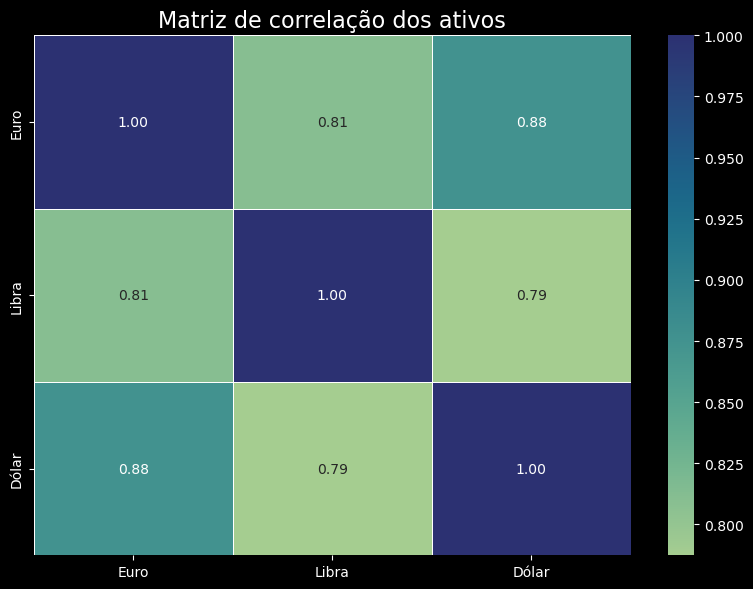

In [5]:
ri = portfolio / portfolio.shift(1) - 1
mi = ri.mean().values*252
sigma = ri.cov()*252
plt.figure(figsize=(8,6))
sns.heatmap(ri.corr(),annot= True, fmt=".2f",linewidths=0.5, cmap='crest')
plt.title('Matriz de correlação dos ativos')
plt.tight_layout()



# Elaboração da otimização por Sharpe

## Construção utilizando método Solve para encopntrar os **pesos** ótimo

harpe Ratio
O Sharpe Ratio é uma medida de desempenho ajustada ao risco, que foi desenvolvida por William F. Sharpe. Ele é utilizado para ajudar os investidores a entender o retorno de um investimento em relação ao seu risco. Quanto maior o Sharpe Ratio, melhor é o desempenho ajustado ao risco de um portfólio.

Fórmula do Sharpe Ratio:
$$ S_p = \frac{R_p – R_f}{\sigma_r} $$
onde: \
**Sp** – Sharpe Ratio. \
**Rp** – Retorno portfolio. \
**Rf** – Retorno livre de risco. \
**σR** – Desvio padrão dos retornos.
 

 Neste exemplo a taxa livre de risco foi considerado como 0%.

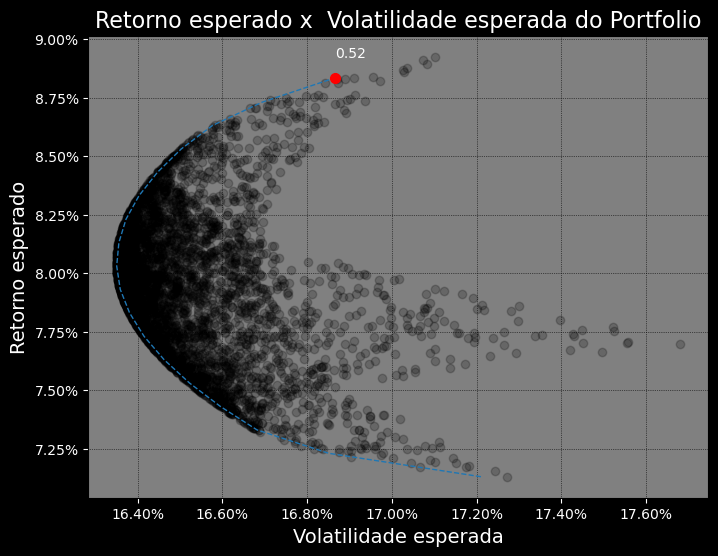

In [35]:
vet_r=[]
vet_vol = []
vet = []
rf = 0.00
for i in range(5000):
    w = np.random.random(len(tickers))
    w = w/np.sum(w) # Pesos e alocação de cada ativo
    retorno = np.sum(w*mi)
    risco = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    sharpe = (retorno-rf) / risco
    vet_r.append(retorno)
    vet_vol.append(risco)
    vet.append(sharpe)


plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.plot(vet_vol,vet_r,'ok',alpha=0.2)
plt.grid()
plt.xlabel('Volatilidade esperada')
plt.ylabel('Retorno esperado')
plt.title('Retorno esperado x  Volatilidade esperada do Portfolio')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))


def f_obj(peso):
    return np.sqrt(np.dot(peso.T,np.dot(sigma,peso)))

x0 = np.array([1 / (len(tickers)) for x in range((len(tickers)))])
bounds = tuple((0,1) for x in range(len(tickers)))
faixa_ret = np.arange(min(vet_r),max(vet_r),0.001)

risk = []
for i in faixa_ret:
    constrains = [{'type' : 'eq', 'fun': lambda x: np.sum(x)-1},
                  {'type' : 'eq', 'fun': lambda x: np.sum(x*mi) - i}]
    outcome = solver.minimize(f_obj,x0,constraints=constrains,bounds=bounds, method='SLSQP')
    risk.append(outcome.fun)
plt.plot(risk,faixa_ret,'--',linewidth=1)

#constrains_ot = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
#result = solver.minimize(neg_ratio, x0, args=(mi, sigma, rf), method='SLSQP', bounds=bounds_pesos, constraints=constrains_ot)
def estatistica_port(peso):
    peso = np.array(peso)
    ret = np.sum(peso* mi)
    vol = np.sqrt(np.dot(peso.T, np.dot(sigma, peso)))
    sharpe = (ret - rf) / vol
    return np.array([ret,vol,sharpe]) 

def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio


constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
result = solver.minimize(neg_sharpe_ratio, x0, args=(mi, sigma, rf), method='SLSQP', bounds=bounds, constraints=constraints)
peso_ot = result.x

ret_ot,vol_ot,sharpe_ot=estatistica_port(peso_ot)
plt.plot(vol_ot,ret_ot,'o',markersize=7,color='r')
plt.annotate(f'{(sharpe_ot):.2f}',xy = (vol_ot*1.0,ret_ot*1.0101),
                color='w')
plt.savefig('Fronteira eficiente.png')


### Comparação com a biblioteca riskfolio
Utilizando a biblioteca riskfolio para encontrar os pesos ótimos e comparando com o obtido pelo Solve

In [7]:
carteira = portfolio.pct_change().dropna()
port = rp.Portfolio(returns=carteira)
port.assets_stats(method_mu="hist", method_cov="hist", d=0.94)

pesos_rp = port.optimization(model="Classic", rm="MV", obj="Sharpe", rf=0.00, hist=True)
pesos_rp['solve_sharpe'] = peso_ot
pesos_rp.style.format("{:.2%}").background_gradient(cmap='YlGn')

,weights,solve_sharpe
Euro,0.00%,0.00%
Libra,10.65%,10.77%
Dólar,89.35%,89.23%
